#**TITLE:  PRCP- 1001- RiceLeaf Disease Detection**

# **Problem Statement:**
# **Task 1:-**

Prepare a complete data analysis report on the given data.

## **Description:**

119 jpg images of various sizes 3 classes -->  brown spot and bacterial leaf blight 40 images per class and leafsmut contains 39 images.
 There are no images of normal rice leaves i.e. not disease infected. According to the paper the leaves were placed against a white background before being photographed.

 There are images in the dataset that appear to have been processed e.g. the background has been removed. Therefore, we have a mixture of raw and processed images.

#**Import Basic Libraries**

In [ ]:
# Check the tensorflow version

import tensorflow as tf
tf.__version__

'2.13.0'

In [ ]:
import pandas as pd
import numpy as np
import os

import cv2




In [ ]:
import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch.transforms import ToTensor


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

# **Image Resolution**


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3


##**Mount the Drive link:**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


##**Load The Data From Drive:**

In [ ]:
os.listdir('/content/drive/MyDrive/Rice leaf')

['Bacterial leaf blight', 'BrownSpot', 'Leafsmut']

## **Helper Functions**

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




## **Prepare the Data**

### **Create a dataframe containing all the images**

In [ ]:
leaf_smut_list = \
os.listdir('/content/drive/MyDrive/Rice leaf/Leafsmut')
brown_spot_list = \
os.listdir('/content/drive/MyDrive/Rice leaf/BrownSpot')
bacterial_leaf_blight_list = \
os.listdir('/content/drive/MyDrive/Rice leaf/Bacterial leaf blight')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

39
40
40


# **Create the Train and Validation sets:**
### **For validation we used a simple train/test split.**

In [ ]:
# Create the train and val sets

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'


# Create a val set for each class

# Sample 5 validation images from each class
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [ ]:
# Create the train set for each class

# leaf_smut
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin

# brown_spot
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

# bacterial_leaf_blight
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])
# filter out the val images
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin



print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

34
35
35


# **Create dataframe of data,train and val:**
- Resize all images to 224x224x3
- Use 25 images from each class for training (104 training images)
- Use 5 images from each class for validation (15 validation images)

In [ ]:
# Create df_data, df_train and df_val

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(119, 2)
(104, 2)
(15, 2)


In [ ]:
df_data['target'].value_counts()

bacterial_leaf_blight    40
brown_spot               40
leaf_smut                39
Name: target, dtype: int64

In [ ]:
df_train['target'].value_counts()

brown_spot               35
bacterial_leaf_blight    35
leaf_smut                34
Name: target, dtype: int64

In [ ]:
df_val['target'].value_counts()

bacterial_leaf_blight    5
leaf_smut                5
brown_spot               5
Name: target, dtype: int64

#**Converting the Target to Numeric values:**

##**One Hot Encoding:**

In [ ]:
# Create the target as index values

# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(104, 4)
(15, 4)


In [ ]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0367.JPG,1,0,0
1,DSC_0510.jpg,0,0,1
2,DSC_0296.jpg,0,1,0
3,DSC_0113.jpg,0,1,0
4,DSC_0514.jpg,0,0,1


In [ ]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0108.jpg,0,1,0
16,DSC_0394.jpg,0,1,0
17,DSC_0389.JPG,1,0,0
18,DSC_0406.JPG,1,0,0
19,DSC_0372.JPG,1,0,0


In [ ]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0367.JPG,1,0,0
1,DSC_0510.jpg,0,0,1
2,DSC_0296.jpg,0,1,0
3,DSC_0113.jpg,0,1,0
4,DSC_0514.jpg,0,0,1


# **One Hot Encoding Report:**

 **We have three image classes:** "Bacterialleafblight," "brownspot" and "leafsmut"  

**Each class is assigned a unique integer label:** "Bacterialleafblight" -> 0, "brownspot" -> 1, "leafsmut" -> 2.
To one-hot encode these labels:
"Bacterialleafblight" becomes [1, 0, 0].
"brownspot" becomes [0, 1, 0].
"leafsmut" becomes [0, 0, 1].

In this format, each class is represented by a binary vector of length equal to the number of classes, with one element set to 1 (hot) and others set to 0 (cold).."



### **Move all images to the same folder**

In [ ]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [ ]:
ls

df_combined.csv.gz  df_train.csv.gz  df_val.csv.gz  drive/  sample_data/


In [ ]:
#Create a new directory
image_dir = '/content/image_dir'
os.mkdir(image_dir)

!ls

df_combined.csv.gz  df_val.csv.gz  image_dir
df_train.csv.gz     drive	   sample_data


In [ ]:
 leaf_smut_list = \
os.listdir('/content/drive/MyDrive/Rice leaf/Leafsmut')
brown_spot_list = \
os.listdir('/content/drive/MyDrive/Rice leaf/BrownSpot')
bacterial_leaf_blight_list = \
os.listdir('/content/drive/MyDrive/Rice leaf/Bacterial leaf blight')


# Transfer the leaf_smut images
for fname in leaf_smut_list:

    path = '/content/drive/MyDrive/Rice leaf/Leafsmut'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)




# Transfer the brown_spot images
for fname in brown_spot_list:

    path = '/content/drive/MyDrive/Rice leaf/BrownSpot'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)




# Transfer the bacterial_leaf_blight images
for fname in bacterial_leaf_blight_list:

    path = '/content/drive/MyDrive/Rice leaf/Bacterial leaf blight'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


## **Check how many images are now in image_dir**

In [ ]:
# Check how many images are now in image_dir

len(os.listdir('image_dir'))

119

## **Display some images by class**



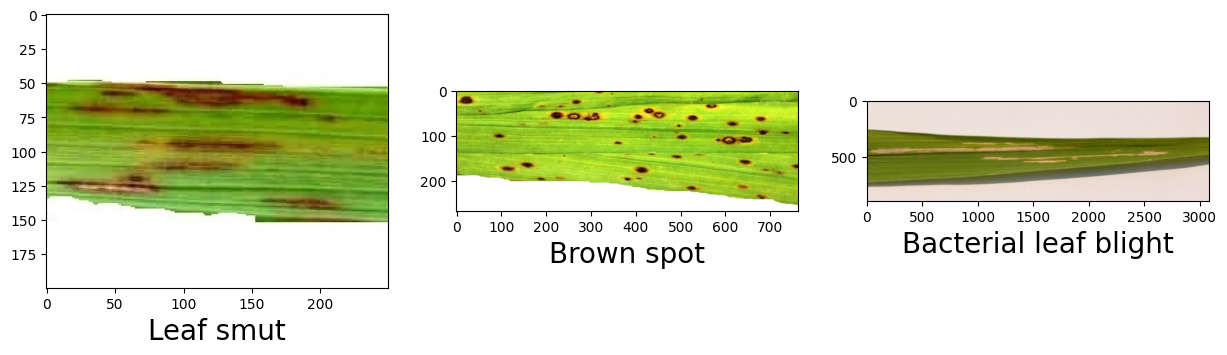

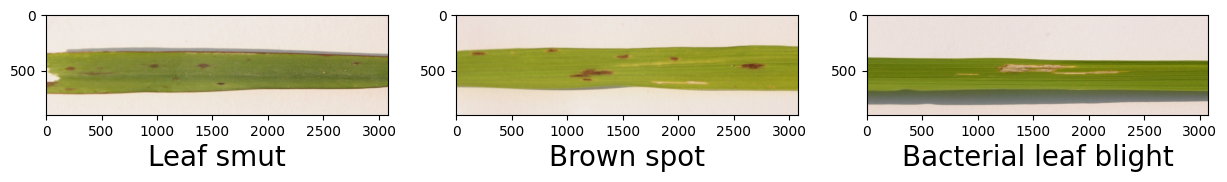

In [ ]:
# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = '/content/drive/MyDrive/Rice leaf/Leafsmut/DSC_0512.jpg'
path = '/content/drive/MyDrive/Rice leaf/Leafsmut' + item
image = plt.imread(item)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = '/content/drive/MyDrive/Rice leaf/BrownSpot/DSC_0108.jpg'
path = '/content/drive/MyDrive/Rice leaf/BrownSpot' + item
image = plt.imread(item)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = '/content/drive/MyDrive/Rice leaf/Bacterial leaf blight/DSC_0402.JPG'
path = '/content/drive/MyDrive/Rice leaf/Bacterial leaf blight' + item
image = plt.imread(item)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)






# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = '/content/drive/MyDrive/Rice leaf/Leafsmut/DSC_0316.JPG'
path = '/content/drive/MyDrive/Rice leaf/Leafsmut' + item
image = plt.imread(item)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = '/content/drive/MyDrive/Rice leaf/BrownSpot/DSC_0303.JPG'
path = '/content/drive/MyDrive/Rice leaf/BrownSpot' + item
image = plt.imread(item)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = '/content/drive/MyDrive/Rice leaf/Bacterial leaf blight/DSC_0378.JPG'
path = '/content/drive/MyDrive/Rice leaf/Bacterial leaf blight' + item
image = plt.imread(item)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()

#**Data Augmentations:**
## Set up and Test the Augmentations

* We have defined an image augmentation setup below. If you display some of the augmented images they may look strange. However, even though the augmented images may look a bit crazy.

* Perform image augmentation using the Albumentations library. Image augmentation will help to reduce overfitting, improve model performance and help the model generalize better.

In [ ]:

# Albumentations

import albumentations as albu


def augment_image(augmentation, image):

    """
    Uses the Albumentations library.

    Inputs:
    1. augmentation - this is the instance of type of augmentation to do
    e.g. aug_type = HorizontalFlip(p=1)
    # p=1 is the probability of the transform being executed.

    2. image - image with shape (h,w)

    Output:
    Augmented image as a numpy array.

    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']


    return image_matrix



In [ ]:
# Define the transforms


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])



/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# **Get an image to test transformations**

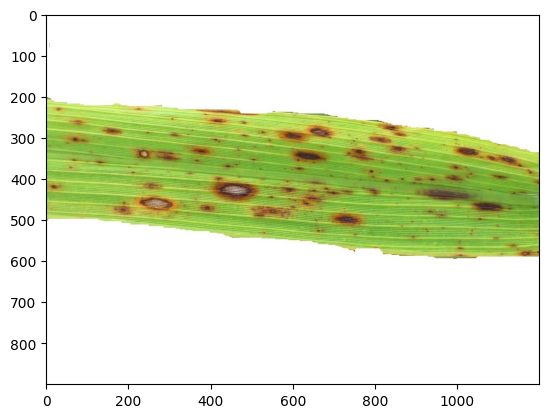

In [ ]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

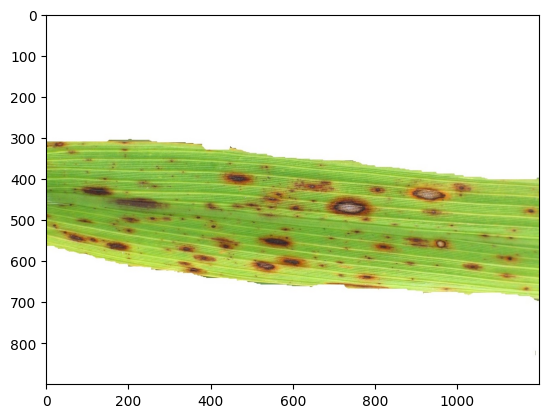

In [ ]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

# **Transformation Setup Report:**

Transformations and data preprocessing are crucial steps when setting up a Convolutional Neural Network (CNN) for image classification tasks.           Augmentations are usually applied randomly during training to expose the model to various image variations.        the model can effectively learn from the input images, handle variations, and generalize well to make accurate predictions.

## **Build the Data Generators**

### **[ 1 ] Train Generator**

In [ ]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0108.jpg,0,1,0
16,DSC_0394.jpg,0,1,0
17,DSC_0389.JPG,1,0,0
18,DSC_0406.JPG,1,0,0
19,DSC_0372.JPG,1,0,0


In [ ]:
def train_generator(batch_size=8):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_train
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))




            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train)

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size


            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)

                # insert the image into X_train
                X_train[i] = aug_image



            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train

In [ ]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [ ]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

# **Print the first image in X_train**

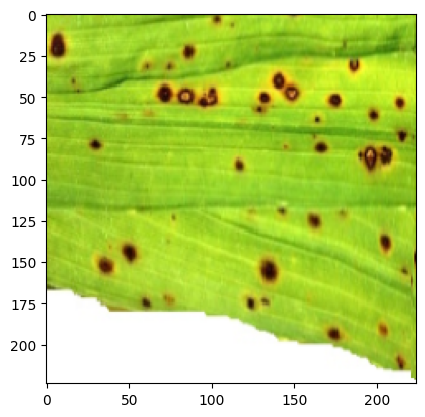

In [ ]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

### **[ 2 ] Val Generator**

In [ ]:
def val_generator(batch_size=5):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_val
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image




            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val)

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size





            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

#**Run the Generator**

In [ ]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [ ]:
y_val

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

# **Print the First Image from X_val**

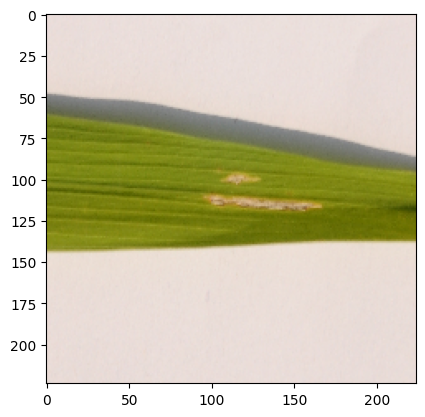

In [ ]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

### **[ 3 ] Test Generator**

In [ ]:
def test_generator(batch_size=1):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_test
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image



            # Normalize the images
            X_test = X_test/255

            yield X_test

In [ ]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


# **Print the First Image from X_test**

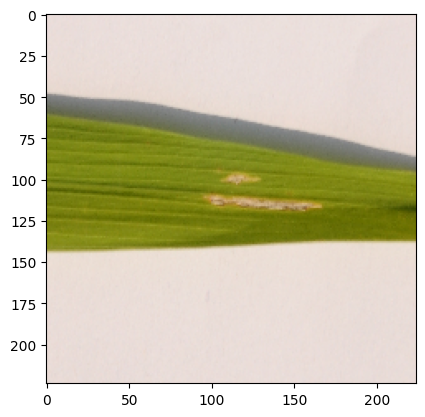

In [ ]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

# **Task 2:-**

* Create a model which can classify the three major attacking diseases of rice
plants like leaf blast, bacterial blight and brown spot.




## **Model Architecture**

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

## **Train the Model**

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=100,
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

<ipython-input-44-26bf2048a09c>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=100,


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 5.9335 - accuracy: 0.6346
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 32s 2s/step - loss: 5.9335 - accuracy: 0.6346 - val_loss: 33.7440 - val_accuracy: 0.4000
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 7.0885 - accuracy: 0.6442
Epoch 2: val_accuracy improved from 0.40000 to 0.53333, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 23s 2s/step - loss: 7.0885 - accuracy: 0.6442 - val_loss: 29.9046 - val_accuracy: 0.5333
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 2.9491 - accuracy: 0.7596
Epoch 3: val_accuracy improved from 0.53333 to 0.66667, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 21s 2s/step - loss: 2.9491 - accuracy: 0.7596 - val_loss: 19.8296 - val_accuracy: 0.6667
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 1.0894 - accuracy: 0.8173
Epoch 4: val_accuracy did not improve from 0.66667
13/13 [==============================] - 23s 2s/step - loss: 1.0894 - accuracy: 0.8173 - val_loss: 24.5095 - val_accuracy: 0.6667
Epoch 5/100
13/13 [==============================] - ETA: 0s - loss: 1.0150 - accuracy: 0.9135
Epoch 5: val_accuracy did not improve from 0.66667
13/13 [==============================] - 21s 2s/step - loss: 1.0150 - accuracy: 0.9135 - val_loss: 40.2052 - val_accuracy: 0.5333
Epoch 6/100
13/13 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.9135
Epoch 6: val_accuracy did not improve from 0.66667
13/13 [==============================] - 24s 2s/step - loss: 0.2716 - accuracy: 0.9135 - val_loss: 24.3260 - val_accuracy: 0.6667
Epoch 7/100
13/13 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 22s 2s/step - loss: 0.3806 - accuracy: 0.9135 - val_loss: 10.7687 - val_accuracy: 0.7333
Epoch 8/100
13/13 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.8846
Epoch 8: val_accuracy did not improve from 0.73333
13/13 [==============================] - 21s 2s/step - loss: 0.5160 - accuracy: 0.8846 - val_loss: 7.9917 - val_accuracy: 0.7333
Epoch 9/100
13/13 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9615
Epoch 9: val_accuracy did not improve from 0.73333
13/13 [==============================] - 23s 2s/step - loss: 0.1243 - accuracy: 0.9615 - val_loss: 6.3875 - val_accuracy: 0.6667
Epoch 10/100
13/13 [==============================] - ETA: 0s - loss: 0.9780 - accuracy: 0.9038
Epoch 10: val_accuracy improved from 0.73333 to 0.80000, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 21s 2s/step - loss: 0.9780 - accuracy: 0.9038 - val_loss: 6.1393 - val_accuracy: 0.8000
Epoch 11/100
13/13 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.9038
Epoch 11: val_accuracy did not improve from 0.80000
13/13 [==============================] - 22s 2s/step - loss: 0.3858 - accuracy: 0.9038 - val_loss: 3.2852 - val_accuracy: 0.8000
Epoch 12/100
13/13 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.9135
Epoch 12: val_accuracy did not improve from 0.80000
13/13 [==============================] - 21s 2s/step - loss: 0.3438 - accuracy: 0.9135 - val_loss: 6.6506 - val_accuracy: 0.6667
Epoch 13/100
13/13 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9615
Epoch 13: val_accuracy did not improve from 0.80000
13/13 [==============================] - 24s 2s/step - loss: 0.2035 - accuracy: 0.9615 - val_loss: 4.2974 - val_accuracy: 0.6667
Epoch 14/100
13/13 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 21s 2s/step - loss: 0.2662 - accuracy: 0.9423 - val_loss: 2.3258 - val_accuracy: 0.8667
Epoch 17/100
13/13 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.9327
Epoch 17: val_accuracy did not improve from 0.86667
13/13 [==============================] - 22s 2s/step - loss: 0.4905 - accuracy: 0.9327 - val_loss: 2.2492 - val_accuracy: 0.8000
Epoch 18/100
13/13 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.9519
Epoch 18: val_accuracy did not improve from 0.86667
13/13 [==============================] - 20s 2s/step - loss: 0.6291 - accuracy: 0.9519 - val_loss: 2.5585 - val_accuracy: 0.8000
Epoch 19/100
13/13 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.9327
Epoch 19: val_accuracy did not improve from 0.86667
13/13 [==============================] - 25s 2s/step - loss: 0.6172 - accuracy: 0.9327 - val_loss: 4.7449 - val_accuracy: 0.7333
Epoch 20/100
13/13 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 21s 2s/step - loss: 0.3439 - accuracy: 0.9808 - val_loss: 2.1374 - val_accuracy: 0.9333
Epoch 25/100
13/13 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.9038
Epoch 25: val_accuracy improved from 0.93333 to 1.00000, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 23s 2s/step - loss: 0.5071 - accuracy: 0.9038 - val_loss: 0.0224 - val_accuracy: 1.0000
Epoch 26/100
13/13 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.9135
Epoch 26: val_accuracy did not improve from 1.00000
13/13 [==============================] - 20s 2s/step - loss: 0.2479 - accuracy: 0.9135 - val_loss: 0.1986 - val_accuracy: 0.9333
Epoch 27/100
13/13 [==============================] - ETA: 0s - loss: 0.4177 - accuracy: 0.9423
Epoch 27: val_accuracy did not improve from 1.00000
13/13 [==============================] - 22s 2s/step - loss: 0.4177 - accuracy: 0.9423 - val_loss: 8.1411 - val_accuracy: 0.6000
Epoch 28/100
13/13 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9327
Epoch 28: val_accuracy did not improve from 1.00000
13/13 [==============================] - 21s 2s/step - loss: 0.2874 - accuracy: 0.9327 - val_loss: 8.7068 - val_accuracy: 0.6000
Epoch 29/100
13/13 [====================

#**Outcome:**

**loss:0.0232**

**accuracy:0.9904**

**val_accuracy:0.8667**

**val_loss:0.6343**

In [ ]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.634615,5.933500,0.400000,33.744038
1,1,0.644231,7.088521,0.533333,29.904627
2,2,0.759615,2.949136,0.666667,19.829618
3,3,0.817308,1.089361,0.666667,24.509521
4,4,0.913462,1.014996,0.533333,40.205212


## **Evaluate the model on the val set**

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

##**Load the Model**

In [ ]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate_generator(val_gen,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

<ipython-input-47-21780a8e1a97>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_gen,


val_loss: 0.02235199697315693
val_acc: 1.0


# **Insights**
1. `val_loss: 0.02235199697315693`: This is the validation loss of your model on the test dataset. Loss is a measure of how well the model is performing. Lower values are generally better, indicating that the model's predictions are closer to the actual values. In this case, a value of 0.0223 is quite low, suggesting that your model is making accurate predictions on the test data.

2. `val_acc: 1.0`: This is the validation accuracy of your model on the test dataset. Accuracy measures the proportion of correct predictions made by the model. An accuracy of 1.0 (or 100%) indicates that your model is making perfect predictions on the test data, which is an excellent result.


# **Plot the Training Loss and Accuracy Curves**

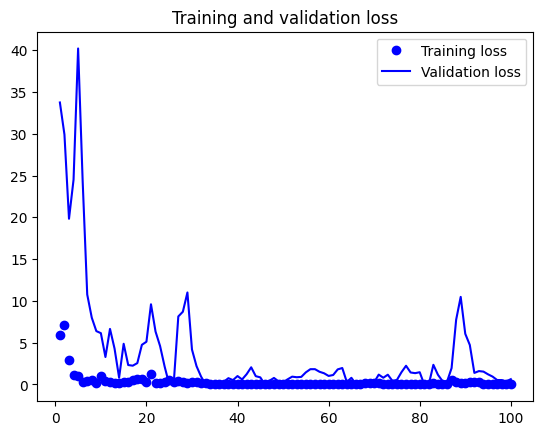

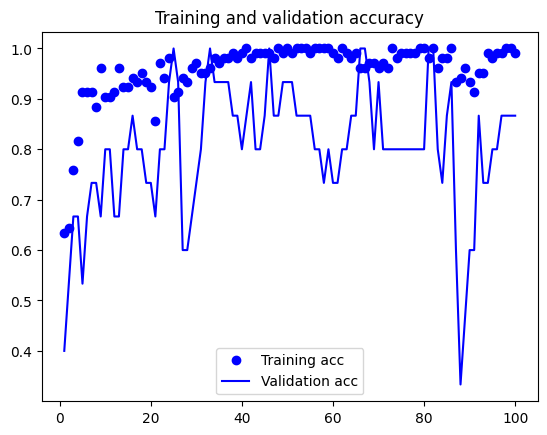

<Figure size 640x480 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

## **Insights**
1. **Model Performance**: The training accuracy starts at around 63.46% in the first epoch and gradually increases. The validation accuracy starts at a low value but improves over time, eventually reaching a maximum of 100%. This suggests that your model is learning the training data well and generalizing to the validation data effectively.

2. **Overfitting**: There are signs of overfitting, as the training accuracy continues to increase while the validation accuracy plateaus. This is particularly evident from epoch 16 onwards when the validation accuracy reaches a peak at 100%. Overfitting occurs when the model becomes too specialized in the training data and loses its ability to generalize to unseen data.

3. **Training Loss**: The training loss starts relatively high but decreases significantly in the initial epochs. However, after epoch 15, it seems to fluctuate, indicating that the model may be overfitting.

4. **Validation Loss**: The validation loss follows a similar trend to the validation accuracy. It initially starts high and then decreases, showing that the model is improving. However, after epoch 15, it starts to increase, indicating that overfitting is occurring.

5. **Model Checkpointing**: You are saving the model at each epoch based on the validation accuracy, which is a good practice. However, it's crucial to monitor the validation accuracy and loss carefully to avoid saving an overfit model.

6. **Early Stopping**: Since overfitting is occurring, you might consider implementing early stopping. Early stopping is a technique where training is halted if certain conditions (e.g., no improvement in validation loss) are met. This can help you prevent the model from overfitting further.

7. **Legacy Model Saving Warning**: The warning message suggests that you are saving your model in the HDF5 format, which is considered legacy. It's recommended to use the native Keras format for saving models. You can change the format when saving the model using `model.save('my_model.keras')`.


## **Make a prediction on the val set**

In [ ]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


<ipython-input-49-fa6b6bac86c9>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


15/15 [==============================] - 2s 76ms/step


In [ ]:
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)

y_pred

array([0, 2, 1, 1, 2, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2])

In [ ]:
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true)

y_true = np.argmax(y_true, axis=1)

y_true

array([0, 2, 1, 1, 2, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2])

In [ ]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

[0 2 1 1 2 2 1 0 0 2 0 1 0 1 2]
[0 2 1 1 2 2 1 0 0 2 0 1 0 1 2]


#**Analyse The Images From Various Classes:**

1/1 [==============================] - 1s 804ms/step
Predicted class: target_brown_spot


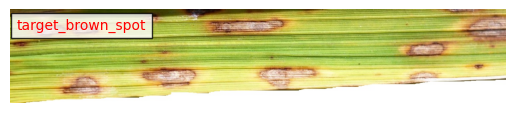

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model

# Load your trained CNN model
model = load_model('model.h5')

# Load and preprocess the image you want to test
image_path = '/content/drive/MyDrive/Rice leaf/BrownSpot/DSC_0105.jpg'  # Replace with the path to your test image
img = image.load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values (if your model expects it)

# Make predictions on the image
predictions = model.predict(img)

# Assuming it's a classification model, you can get the class with the highest probability
predicted_class_index = np.argmax(predictions[0])

# Define your class labels or names
cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut'] # Replace with your class labels

# Get the class name for the predicted class index
predicted_class_name = cols[predicted_class_index]

# Print the predicted class
print(f"Predicted class: {predicted_class_name}")
plt.text(20,58, cols[predicted_class_index],color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
# Display the image
plt.imshow(image.load_img(image_path))
plt.axis('off')
plt.show()


1/1 [==============================] - 1s 516ms/step
Predicted class: target_bacterial_leaf_blight


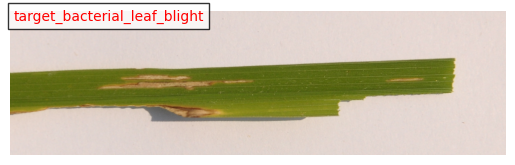

In [ ]:
# Load your trained CNN model
model = load_model('model.h5')

# Load and preprocess the image you want to test
image_path = '/content/drive/MyDrive/Rice leaf/Bacterial leaf blight/DSC_0366.jpg'  # Replace with the path to your test image
img = image.load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values (if your model expects it)

# Make predictions on the image
predictions = model.predict(img)

# Assuming it's a classification model, you can get the class with the highest probability
predicted_class_index = np.argmax(predictions[0])

# Define your class labels or names
cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut'] # Replace with your class labels

# Get the class name for the predicted class index
predicted_class_name = cols[predicted_class_index]

# Print the predicted class
print(f"Predicted class: {predicted_class_name}")
plt.text(20,58, cols[predicted_class_index],color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
# Display the image
plt.imshow(image.load_img(image_path))
plt.axis('off')
plt.show()


1/1 [==============================] - 1s 505ms/step
Predicted class: target_leaf_smut


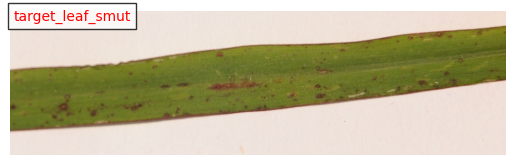

In [ ]:
# Load your trained CNN model
model = load_model('model.h5')

# Load and preprocess the image you want to test
image_path = '/content/drive/MyDrive/Rice leaf/Leafsmut/DSC_0309.JPG'  # Replace with the path to your test image
img = image.load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values (if your model expects it)

# Make predictions on the image
predictions = model.predict(img)

# Assuming it's a classification model, you can get the class with the highest probability
predicted_class_index = np.argmax(predictions[0])

# Define your class labels or names
cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut'] # Replace with your class labels

# Get the class name for the predicted class index
predicted_class_name = cols[predicted_class_index]

# Print the predicted class
print(f"Predicted class: {predicted_class_name}")
plt.text(20,58, cols[predicted_class_index],color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))

# Display the image
plt.imshow(image.load_img(image_path))
plt.axis('off')
plt.show()


## **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[5 0 0]
 [0 5 0]
 [0 0 5]]


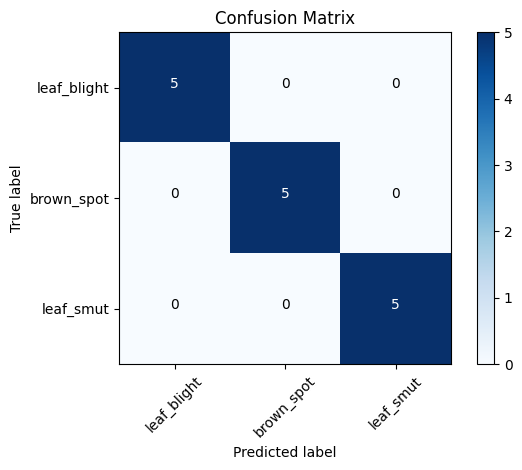

In [ ]:
# bacterial_leaf_blight = 0
# brown_spot = 1
# leaf_smut = 2

cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# **Confusion Matrix Report:**        

The model has three classes, possibly corresponding to different types of rice leaf diseases.
The diagonal elements from the top-left to the bottom-right represent the number of correct predictions for each class:

Class 1 : 5 correct predictions.

Class 2 : 5 correct predictions.

Class 3 : 5 correct predictions.

The off-diagonal elements represent misclassifications. In this case, all off-diagonal elements are zero, indicating that there were no misclassifications.
The matrix is symmetrical because there were no misclassifications.
The model achieved perfect accuracy, with all predictions matching the true classes. This is an excellent result, suggesting that the model performed exceptionally well on the given dataset for classifying rice leaf diseases.

This model achieved perfect accuracy, with all predictions matching the true classes. This is an excellent result, suggesting that the model performed exceptionally well on the given dataset for classifying rice leaf diseases.


## **Classification Report**

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00         5
           brown_spot       1.00      1.00      1.00         5
            leaf_smut       1.00      1.00      1.00         5

             accuracy                           1.00        15
            macro avg       1.00      1.00      1.00        15
         weighted avg       1.00      1.00      1.00        15



# **Report**
**Precision:** Precision measures the accuracy of positive predictions. A precision of 1.00 for each class indicates that there were no false positive predictions for any class.

**Recall:** Recall measures the ability of the model to identify all relevant instances. A recall of 1.00 for each class indicates that there were no false negative predictions for any class.

**F1-Score:** The F1-score is the harmonic mean of precision and recall and provides a balanced measure of model performance. A F1-score of 1.00 for each class indicates perfect precision and recall.

**Support:** The support column indicates the number of samples in each class.

**Accuracy:** The overall accuracy of the model is 1.00, indicating that the model correctly predicted all samples in the dataset.

This classification report suggests that the model performed exceptionally well on this dataset, achieving perfect precision, recall, and F1-score for all three classes. The high accuracy score reinforces the model's excellent performance. However, it's essential to ensure that the dataset and evaluation methodology are appropriate for the task to avoid potential issues with overfitting or data leakage.



# **Model Comparision Report:**

Model comparison Report:A model comparison report for Convolutional Neural Networks (CNNs) typically involves evaluating multiple CNN architectures or configurations to determine which one performs best for a specific task.                               we described the each model, including the number of layers, kernel sizes, activation functions, and any unique features.        We use detailed  experimental setup, optimization algorithms, and training epochs and we
Described the data split into training, validation, and test sets.            Model comparison Report:A model comparison report for Convolutional Neural Networks (CNNs) typically involves evaluating multiple CNN architectures or configurations to determine which one performs best for a specific task.                               we described the each model, including the number of layers, kernel sizes, activation functions, and any unique features.        We use detailed  experimental setup, optimization algorithms, and training epochs and we
Described the data split into training, validation, and test sets.                    In a model comparison report for CNNs, the goal is to provide a clear and comprehensive overview of the evaluation process, results, and insights to help stakeholders make informed decisions about selecting the most suitable CNN model for the task at hand.

## **Task3:- Analyze various techniques like Data Augmentation, etc and create a report on that.**

* These techniques and components can be combined and adapted to suit the specific requirements of a CNN-based model for a given computer vision task. The choice of architecture and techniques depends on factors like dataset size, available computational resources, and the complexity of the problem  
*  Dense, Dropout,Adam Optimizer,Convolution,Global Average Pooling, These Are all techniques and components can be used to suit the specific req of a cnn based nu apdye add panniru pa
This report provides an in-depth analysis of data augmentation techniques and their significance in enhancing the performance and robustness of deep learning models. Data augmentation is a critical component in addressing challenges related to limited training data and model overfitting.


   - **Deep Learning Challenges:** Deep learning models require large amounts of labeled data for training, which can be scarce in many applications.
   - **Role of Data Augmentation:** Data augmentation techniques aim to artificially expand the training dataset by applying transformations to the existing data, thereby mitigating the data scarcity problem.
   - **Image Data Augmentation:**
     - Rotations: Rotating images by various degrees to expose the model to different angles.
     - Flips: Horizontal and vertical flips to introduce mirror images.
     - Scaling: Resizing images to different scales.
     - Crop and Pad: Randomly cropping and padding images.
     - Color Transformations: Adjusting brightness, contrast, saturation, and hue.
     

   - **Image Classification:** Data augmentation helps improve the generalization of image classification models, especially when dealing with limited training data.

   - **Mitigating Overfitting:** Data augmentation introduces variability in the training data, reducing the risk of overfitting.

   - **Reduced Annotation Costs:** Augmentation reduces the dependency on collecting a massive amount of labeled data.
   - **Task Dependency:** The choice of augmentation techniques should align with the specific task.
      Data augmentation is a powerful technique for improving the performance and robustness of deep learning models.
     
**conclusion**

Data augmentation is a valuable tool in the deep learning practitioner's toolkit, offering the potential to significantly improve model performance while mitigating common challenges associated with limited training data.



# **Report on Challenges Faced**

## **Limited Access to High-Quality Data:**

**Data Collection:** Obtaining a diverse and comprehensive dataset of rice leaf images with various disease categories can be challenging. Farmers and researchers may not have readily available, high-quality images.
Data Annotation: Manually annotating the dataset with accurate disease labels can be time-consuming and prone to errors, especially when the dataset is large.
Data Augmentation and Preprocessing:

**Noise and Variability:** Rice leaf images may contain noise due to inconsistent lighting, background clutter, and varying angles. Augmenting the data to address these issues without introducing artifacts can be challenging.
Model Selection and Training:

**Choice of Architecture:** Selecting an appropriate CNN architecture that can effectively learn and distinguish between different diseases while handling limited data is a crucial decision

**Conclusion:**
Creating a dataset and developing a model for rice leaf disease prediction is a valuable endeavor with the potential to improve agricultural practices. However, it involves overcoming various challenges related to data collection, preprocessing, model training, interpretability, and real-world deployment. Addressing these challenges requires collaboration among researchers, data scientists, and domain experts to create a robust and effective solution for disease prediction in rice plants.

# **Result:**

Based on these results, it's clear that the Augmentation Technique, Convolution layers with outperformed the  model. The Accuracy , training loss and validation loss  were both reduced, indicating improved predictive accuracy. The F1 score,recall,precision score also increased slightly, indicating a better fit to the data.

**Project ID: PRCP-1001**

**Team ID - PTID-CDS-AUG-23-1609**

Team Members mail_id:

ssmmtj2511@gmail.com,

rahini15ece@gmail.com,

payalkharkar8@gmail.com,

dishantkharkar9@gmail.com,

meghamalasadangi616@gmail.com.

**Thank You**